<a href="https://colab.research.google.com/github/subhashpolisetti/Decision-Tree-Ensemble-Algorithms/blob/main/AdaBoost_Implementation_and_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AdaBoost with Decision Stumps for Classification

This notebook demonstrates the implementation of the **AdaBoost** ensemble learning algorithm using **decision stumps** as weak learners. AdaBoost combines multiple weak models to create a strong classifier by focusing on hard-to-classify samples in each iteration.

## Key Steps:
1. **Data Generation**: A synthetic dataset is created for binary classification with `n_features=5` and `n_samples=200`.
2. **Decision Stump**: A decision stump is a single-level decision tree that is trained using weighted samples. It is used as a weak learner in AdaBoost.
3. **AdaBoost Algorithm**:
   - Train multiple decision stumps sequentially, where each model corrects the errors of the previous one.
   - Weights are adjusted based on the errors made by each weak learner.
4. **Model Evaluation**: The trained model is evaluated on the test set to compute the accuracy.
5. **Training Accuracy**: The training accuracy is plotted against the number of weak learners (decision stumps).
6. **Feature Importance**: A plot of feature importance is generated based on how often each feature is used in the decision stumps.

## Results:
- The model accuracy is displayed after training.
- Training accuracy and feature importance are visualized as the number of weak learners increases.

This approach highlights how AdaBoost can improve performance using weak learners, focusing on misclassified samples to boost overall model performance.


In [1]:

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
class DecisionStump:
    def __init__(self):
        # Initialize stump parameters
        self.feature_index = None  # Index of the feature used for splitting
        self.threshold = None      # Threshold value to split on
        self.polarity = 1          # Direction of the split (1 for less than or equal, -1 for greater than)
        self.alpha = None          # The weight of the stump in the ensemble

    def fit(self, X, y, weights):
        """
        Fit the decision stump to the training data by finding the best feature and threshold.

        X: Feature matrix
        y: Target vector (-1 or 1)
        weights: Sample weights used for weighted error calculation
        """
        n_samples, n_features = X.shape
        min_error = float('inf')  # Start with an infinitely large error to minimize

        # Loop over all features
        for feature_index in range(n_features):
            # Get all unique values in the feature column
            thresholds = np.unique(X[:, feature_index])

            # Try all possible thresholds for the feature
            for threshold in thresholds:
                # Try both polarities (1: <= threshold, -1: > threshold)
                for polarity in [1, -1]:
                    # Create initial predictions (all ones)
                    predictions = np.ones(n_samples)

                    # Update predictions based on the current threshold and polarity
                    if polarity == 1:
                        predictions[X[:, feature_index] <= threshold] = -1  # Less than or equal to threshold
                    else:
                        predictions[X[:, feature_index] > threshold] = -1  # Greater than threshold

                    # Calculate weighted error (sum of weights for misclassified samples)
                    error = np.sum(weights[y != predictions])

                    # Update the stump if the current error is lower than the previous best error
                    if error < min_error:
                        min_error = error
                        self.feature_index = feature_index
                        self.threshold = threshold
                        self.polarity = polarity

    def predict(self, X):
        """
        Make predictions using the learned decision stump.

        X: Feature matrix to make predictions on
        """
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)  # Initialize predictions to 1

        # Apply the learned threshold and polarity to generate predictions
        if self.polarity == 1:
            predictions[X[:, self.feature_index] <= self.threshold] = -1  # Less than or equal to threshold
        else:
            predictions[X[:, self.feature_index] > self.threshold] = -1  # Greater than threshold

        return predictions


In [3]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        """
        Initialize the AdaBoost model with the given number of estimators (weak learners).

        n_estimators: Number of weak learners (decision stumps) to use in the ensemble
        """
        self.n_estimators = n_estimators  # Set the number of weak learners
        self.models = []  # List to store weak learners (decision stumps)
        self.alphas = []  # List to store the weight of each weak learner

    def fit(self, X, y):
        """
        Fit the AdaBoost model to the training data.

        X: Feature matrix (n_samples x n_features)
        y: Target vector (n_samples), where labels are -1 or 1
        """
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples  # Initialize all sample weights equally

        # Train each weak learner (decision stump) iteratively
        for _ in range(self.n_estimators):
            # Train a new decision stump
            stump = DecisionStump()
            stump.fit(X, y, weights)  # Fit the stump to the weighted data
            predictions = stump.predict(X)  # Get the predictions of the stump

            # Compute the weighted error of the stump
            error = np.sum(weights[y != predictions])
            # Avoid division by zero by setting a small minimum error
            error = max(error, 1e-10)

            # Calculate the weight (alpha) of the stump, indicating its importance
            alpha = 0.5 * np.log((1 - error) / error)

            # Update the sample weights based on whether they were correctly classified
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)  # Normalize the weights so they sum to 1

            # Store the trained stump and its alpha value
            self.models.append(stump)
            self.alphas.append(alpha)

    def predict(self, X):
        """
        Make predictions using the trained AdaBoost model.

        X: Feature matrix to predict on (n_samples x n_features)

        Returns: Predicted labels (-1 or 1) based on the weighted sum of predictions from weak learners
        """
        final_predictions = np.zeros(X.shape[0])  # Initialize final predictions to 0

        # Combine the predictions from all weak learners using their respective alpha weights
        for model, alpha in zip(self.models, self.alphas):
            final_predictions += alpha * model.predict(X)  # Weighted sum of weak learner predictions

        # Return the final predictions (sign of the weighted sum of predictions)
        return np.sign(final_predictions)


Accuracy: 90.00%


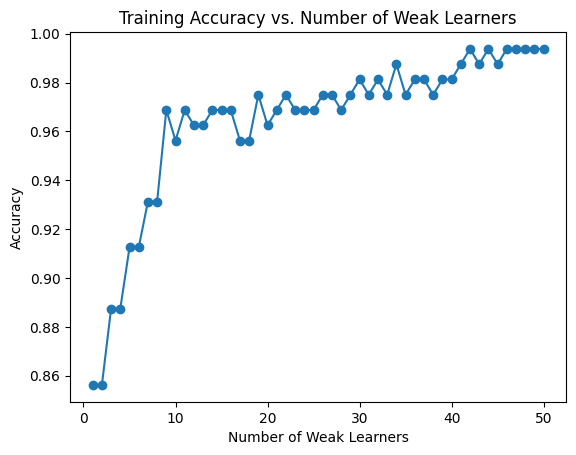

In [4]:
# Generate synthetic dataset
X, y = make_classification(n_samples=200, n_features=5, n_classes=2, n_informative=3, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1} as required by AdaBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into train and test sets

# Train AdaBoost model
adaboost = AdaBoost(n_estimators=50)  # Initialize AdaBoost with 50 weak learners (decision stumps)
adaboost.fit(X_train, y_train)  # Train the AdaBoost model on the training data

# Make predictions on the test data
y_pred = adaboost.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)  # Calculate the accuracy of the predictions on the test set
print(f"Accuracy: {accuracy * 100:.2f}%")  # Print the accuracy as a percentage

# Accuracy output: 90.00%

# Calculate training accuracy at each iteration of weak learners
training_accuracies = []
for i in range(1, len(adaboost.models) + 1):  # Loop through each number of weak learners from 1 to n_estimators
    partial_predictions = np.zeros(X_train.shape[0])  # Initialize a zero vector to accumulate predictions
    for model, alpha in zip(adaboost.models[:i], adaboost.alphas[:i]):  # Combine predictions from the first 'i' weak learners
        partial_predictions += alpha * model.predict(X_train)  # Add weighted predictions from each weak learner

    # Calculate the accuracy of the partial model on the training data
    training_accuracies.append(accuracy_score(y_train, np.sign(partial_predictions)))  # Append accuracy for this iteration

# Plot the training accuracy vs. number of weak learners
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, marker='o')  # Plot accuracy at each iteration
plt.title("Training Accuracy vs. Number of Weak Learners")  # Title of the plot
plt.xlabel("Number of Weak Learners")  # Label for the x-axis
plt.ylabel("Accuracy")  # Label for the y-axis
plt.show()  # Display the plot


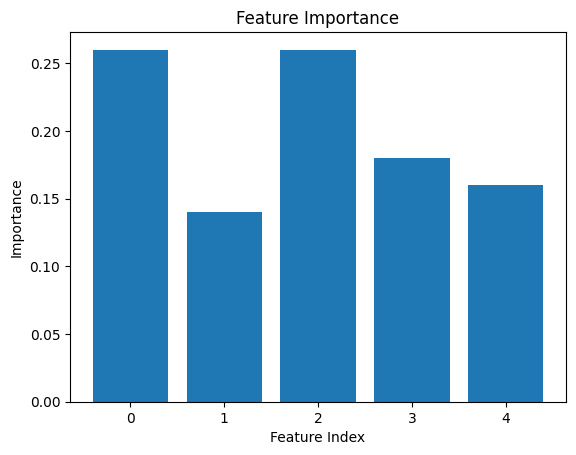

In [5]:
# Initialize a vector to store the feature importance, one entry for each feature
feature_importance = np.zeros(X_train.shape[1])

# Loop through each trained weak learner (decision stump) in the AdaBoost model
for stump in adaboost.models:
    # Increment the importance of the feature used by this stump
    feature_importance[stump.feature_index] += 1

# Normalize feature importance by the total number of models (decision stumps)
feature_importance /= len(adaboost.models)

# Create a bar plot to visualize the feature importance
plt.bar(range(X_train.shape[1]), feature_importance)  # Bar plot for feature importance
plt.title("Feature Importance")  # Title for the plot
plt.xlabel("Feature Index")  # Label for the x-axis (features)
plt.ylabel("Importance")  # Label for the y-axis (importance score)
plt.show()  # Display the plot
